In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from utils import set_seed, load_dataset, plot_feature_maps, plot_training_progress, evaluate_model
from transform import TensorAugment, SimpleResize
from models import SimpleCNN

In [2]:
cdm_model='IllustrisTNG'

cdm_file=f'/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/{cdm_model}/Maps_Mtot_{cdm_model}_LH_z=0.00.npy'
wdm_file='/n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/boxes/Maps_Mtot_IllustrisTNG_WDM_z=0.00.npy'

In [3]:
# Sample indices
all_indices = random.sample(range(15000), 1000)
random.shuffle(all_indices)

val_test_transform = SimpleResize(
    size=(256, 256),
    apply_log=True  # Keep log scale
)

test_dataset = load_dataset(all_indices, transform=val_test_transform, cdm_file=cdm_file, wdm_file=wdm_file)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, 
                         num_workers=1, pin_memory=True)

Loading CDM data from /n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy...
CDM data shape: (15000, 256, 256)
Loading WDM data from /n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/boxes/Maps_Mtot_IllustrisTNG_WDM_z=0.00.npy...
WDM data shape: (15360, 256, 256)
Created dataset with 2000 samples


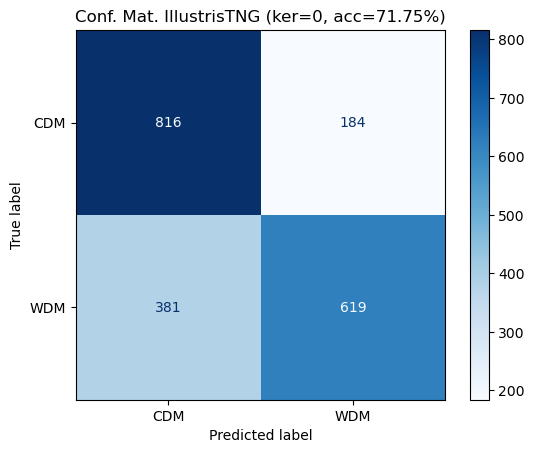

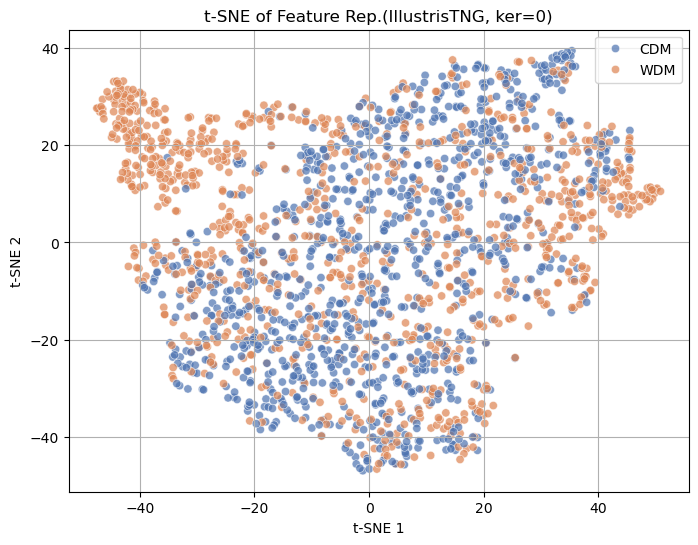

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import seaborn as sns

# --- Set Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

kern = 0

# --- Load Model ---
model = SimpleCNN().to(device)
checkpoint = torch.load(f"best_cnn_model_blur_{kern}.pt", map_location=device, weights_only=True)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()


# --- Inference and Feature Extraction ---
all_preds, all_labels, features = [], [], []

with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)

        # Pass through feature extractor
        feats = model.features(x)
        pooled_feats = model.cnn_head(feats)  # shape [B, 256]

        # Classifier
        logits = model.fc(pooled_feats).squeeze(1)
        preds = (torch.sigmoid(logits) > 0.5).float()

        # Store flattened features for t-SNE
        features.append(pooled_feats.cpu())  # or full_input.cpu() if you want both
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())


features = torch.cat(features, dim=0).numpy()
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["CDM", "WDM"])
disp.plot(cmap="Blues")
plt.title(f"Conf. Mat. {cdm_model} (ker={kern}, acc={acc*100:.2f}%)")
plt.savefig(f'cm_{cdm_model}_{kern}.png')
plt.show()

# --- t-SNE Plot ---
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1],
                hue=["CDM" if int(lbl)==0 else "WDM" for lbl in all_labels],
                palette="deep", alpha=0.7)
                # hue=softscores,
                # palette="viridis", alpha=0.7)
plt.title(f"t-SNE of Feature Rep.({cdm_model}, ker={kern})")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(True)
plt.savefig(f'tSNE_{cdm_model}_{kern}.png')
plt.show()


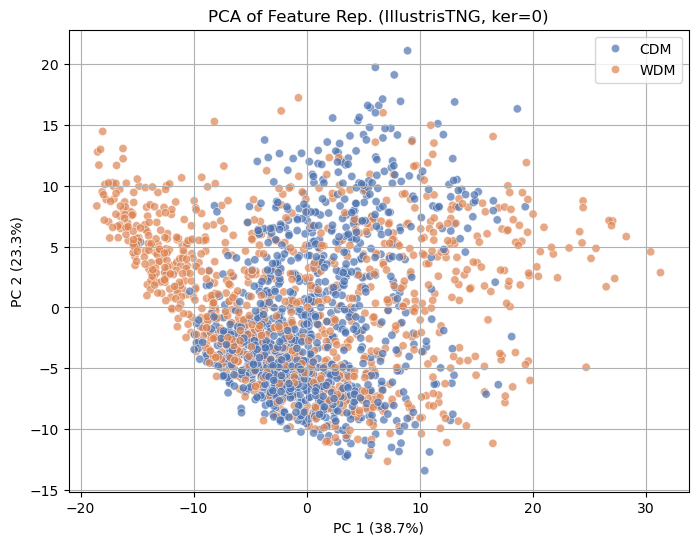

In [5]:
from sklearn.decomposition import PCA

# --- PCA Plot ---
pca = PCA(n_components=2)
pca_results = pca.fit_transform(features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_results[:, 0], y=pca_results[:, 1],
                hue=["CDM" if int(lbl)==0 else "WDM" for lbl in all_labels],
                palette="deep", alpha=0.7)
plt.title(f"PCA of Feature Rep. ({cdm_model}, ker={kern})")
plt.xlabel(f"PC 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend()
plt.grid(True)
plt.savefig(f'pca_{cdm_model}_{kern}.png')
plt.show()


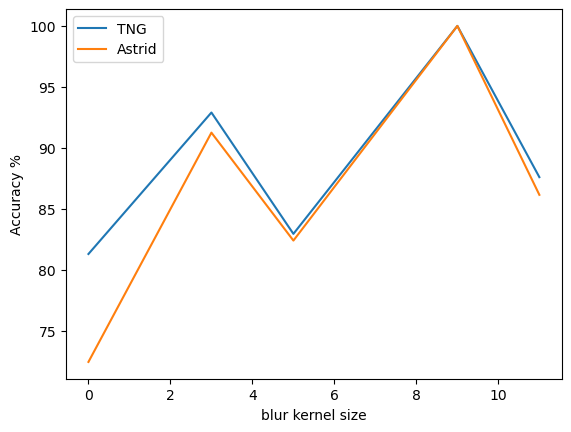

In [34]:
tng=[81.3,92.9,82.95,100,87.6]
astrid=[72.45,91.25,82.4,100,86.15]

plt.plot([0,3,5,9,11],tng,label='TNG')
plt.plot([0,3,5,9,11],astrid,label='Astrid')
plt.legend()
plt.ylabel('Accuracy %')
plt.xlabel('blur kernel size')
plt.savefig('acc.png')
plt.show()

In [17]:
import numpy as np
import Pk_library as PKL

# parameters
BoxSize = 25.0     #Mpc/h
MAS     = 'None'  #MAS used to create the image; 'NGP', 'CIC', 'TSC', 'PCS' o 'None'
threads = 1       #number of openmp threads

cdm_sample = np.load(cdm_file)
# create an empty image
delta = np.log1p(cdm_sample[0])

# compute the Pk of that image
Pk2D = PKL.Pk_plane(delta, BoxSize, MAS, threads)

# get the attributes of the routine
k      = Pk2D.k      #k in h/Mpc
Pk     = Pk2D.Pk     #Pk in (Mpc/h)^2
Nmodes = Pk2D.Nmodes #Number of modes in the different k bins


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds


Lowest frequency: 0.30337902366992636
Highest frequency: 45.49512128674168


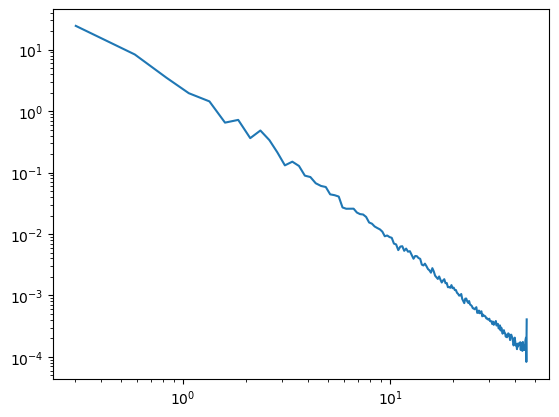

In [18]:
import matplotlib.pyplot as plt
print('Lowest frequency:',np.min(k))
print('Highest frequency:',np.max(k))
plt.loglog(k,Pk)
plt.show()

In [40]:
from scipy.ndimage import gaussian_filter
delta_smoothed = gaussian_filter(delta,sigma=0.5)
Pk2D_smoothed = PKL.Pk_plane(delta_smoothed, BoxSize, MAS, threads)
k_smoothed      = Pk2D_smoothed.k      #k in h/Mpc
Pk_smoothed     = Pk2D_smoothed.Pk     #Pk in (Mpc/h)^2


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds


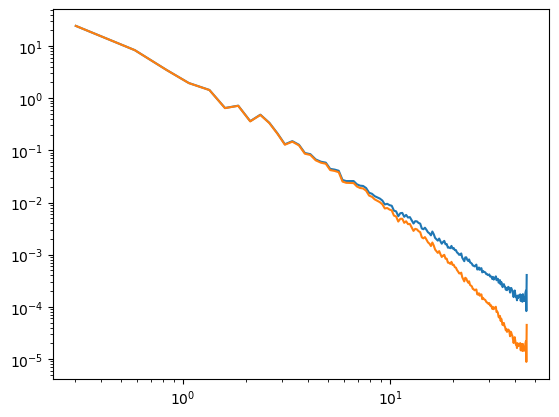

In [41]:
plt.loglog(k,Pk)
plt.loglog(k_smoothed,Pk_smoothed)
plt.show()

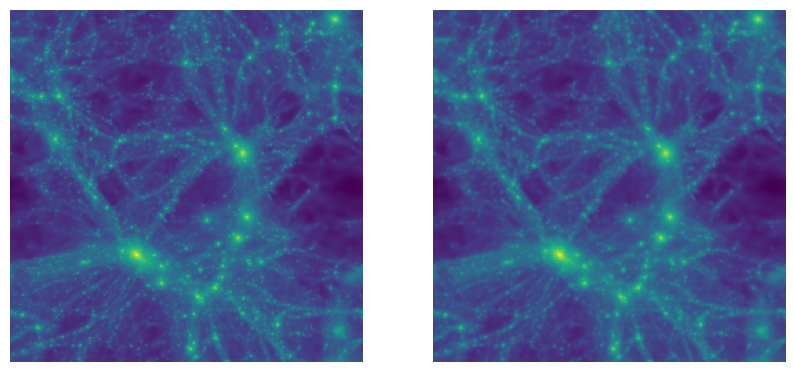

In [48]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(delta)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(delta_smoothed)
plt.axis('off')
plt.show()

In [10]:
import smoothing_library as SL
import numpy as np

# we take as field a temperature image from the CAMELS Multifield Dataset
field = np.load(cdm_file)[0] #only take the first image

BoxSize = 25.0 #Mpc/h
grid    = field.shape[0]
R       = 0.0 #only matter for configuration space filters
Filter  = 'Top-Hat-k'
threads = 1
kmin    = 5  #h/Mpc
kmax    = 50 #h/Mpc

# compute the filter in Fourier space
W_k = SL.FT_filter_2D(BoxSize, R, grid, Filter, threads, kmin, kmax)

# smooth the field
field_smoothed = SL.field_smoothing_2D(field, W_k, threads)

In [ ]:
k_smoothed      = Pk2D_smoothed.k      #k in h/Mpc
Pk_smoothed     = Pk2D_smoothed.Pk 
plt.loglog(k,Pk)
plt.loglog(k_smoothed,Pk_smoothed)
plt.show()

In [11]:
Pk2D_smoothed = PKL.Pk_plane(np.log1p(field_smoothed), BoxSize, MAS, threads)
k_smoothed      = Pk2D_smoothed.k      #k in h/Mpc
Pk_smoothed     = Pk2D_smoothed.Pk     #Pk in (Mpc/h)^2


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds


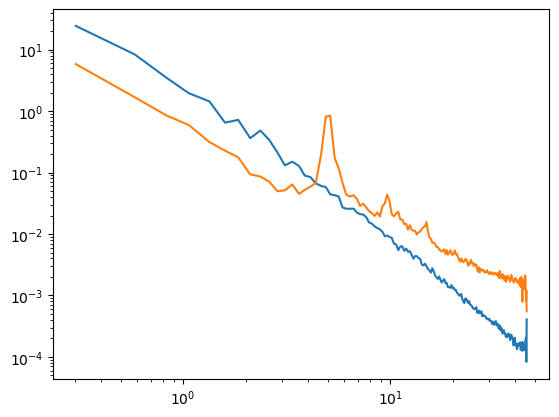

In [12]:
plt.loglog(k,Pk)
plt.loglog(k_smoothed,Pk_smoothed)
plt.show()